In [1]:
import torch
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


tensor(1)


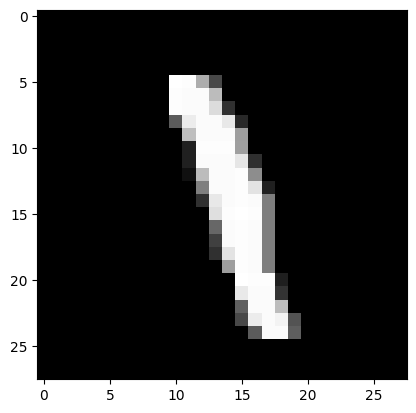

In [3]:
train_features, train_labels = next(iter(train_dataloader))

print(train_labels[0])
plt.imshow(torch.reshape(train_features[0], (28, 28)), cmap='gray')

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(1568, 64)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(64, 64)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(64, 10)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

def cnn_loss(pred, target):

    # Perform crossentropy loss on every 10 units batch
    loss_fn = nn.CrossEntropyLoss()

    return loss_fn(pred, target)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)


In [7]:
ALPHA=0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=ALPHA)

def train_step(epoch_idx, model, loss_fn):
    for idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        running_loss = 0
        running_vloss = 0
        for idx, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            running_loss += loss

        avg_loss = running_loss / (idx + 1)
        
        for idx, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            vloss = loss_fn(pred, labels)
            running_vloss += vloss
            
        avg_vloss = running_vloss / (idx + 1)
    
        print(f"Epoch {epoch_idx}:\nTraining Loss: {avg_loss}\nTest Loss: {avg_vloss}") 
        
    return avg_loss, avg_vloss

In [8]:
EARLY_STOP = 5
losses = []
vlosses = []

early_stopping_cnt = 0

mn = 10000

cnn.train()

for i in range(50):
    loss, vloss = train_step(i, cnn, cnn_loss)
    
    if vloss < mn:
        mn = vloss
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1

    if early_stopping_cnt == EARLY_STOP:
        break
    
    losses.append(loss)
    vlosses.append(vloss)

Epoch 0:
Training Loss: 1.4861880540847778
Test Loss: 1.4860806465148926
Epoch 1:
Training Loss: 1.4829062223434448
Test Loss: 1.4830622673034668
Epoch 2:
Training Loss: 1.4796963930130005
Test Loss: 1.479438066482544
Epoch 3:
Training Loss: 1.4882935285568237
Test Loss: 1.48753821849823
Epoch 4:
Training Loss: 1.4776170253753662
Test Loss: 1.4778066873550415
Epoch 5:
Training Loss: 1.4766931533813477
Test Loss: 1.4764268398284912
Epoch 6:
Training Loss: 1.4744876623153687
Test Loss: 1.4743608236312866
Epoch 7:
Training Loss: 1.4764690399169922
Test Loss: 1.476163387298584
Epoch 8:
Training Loss: 1.4730104207992554
Test Loss: 1.472733736038208
Epoch 9:
Training Loss: 1.4735249280929565
Test Loss: 1.4737412929534912
Epoch 10:
Training Loss: 1.4755038022994995
Test Loss: 1.4753047227859497
Epoch 11:
Training Loss: 1.4735383987426758
Test Loss: 1.4736568927764893
Epoch 12:
Training Loss: 1.4720458984375
Test Loss: 1.4712846279144287
Epoch 13:
Training Loss: 1.472949504852295
Test Loss: 1.

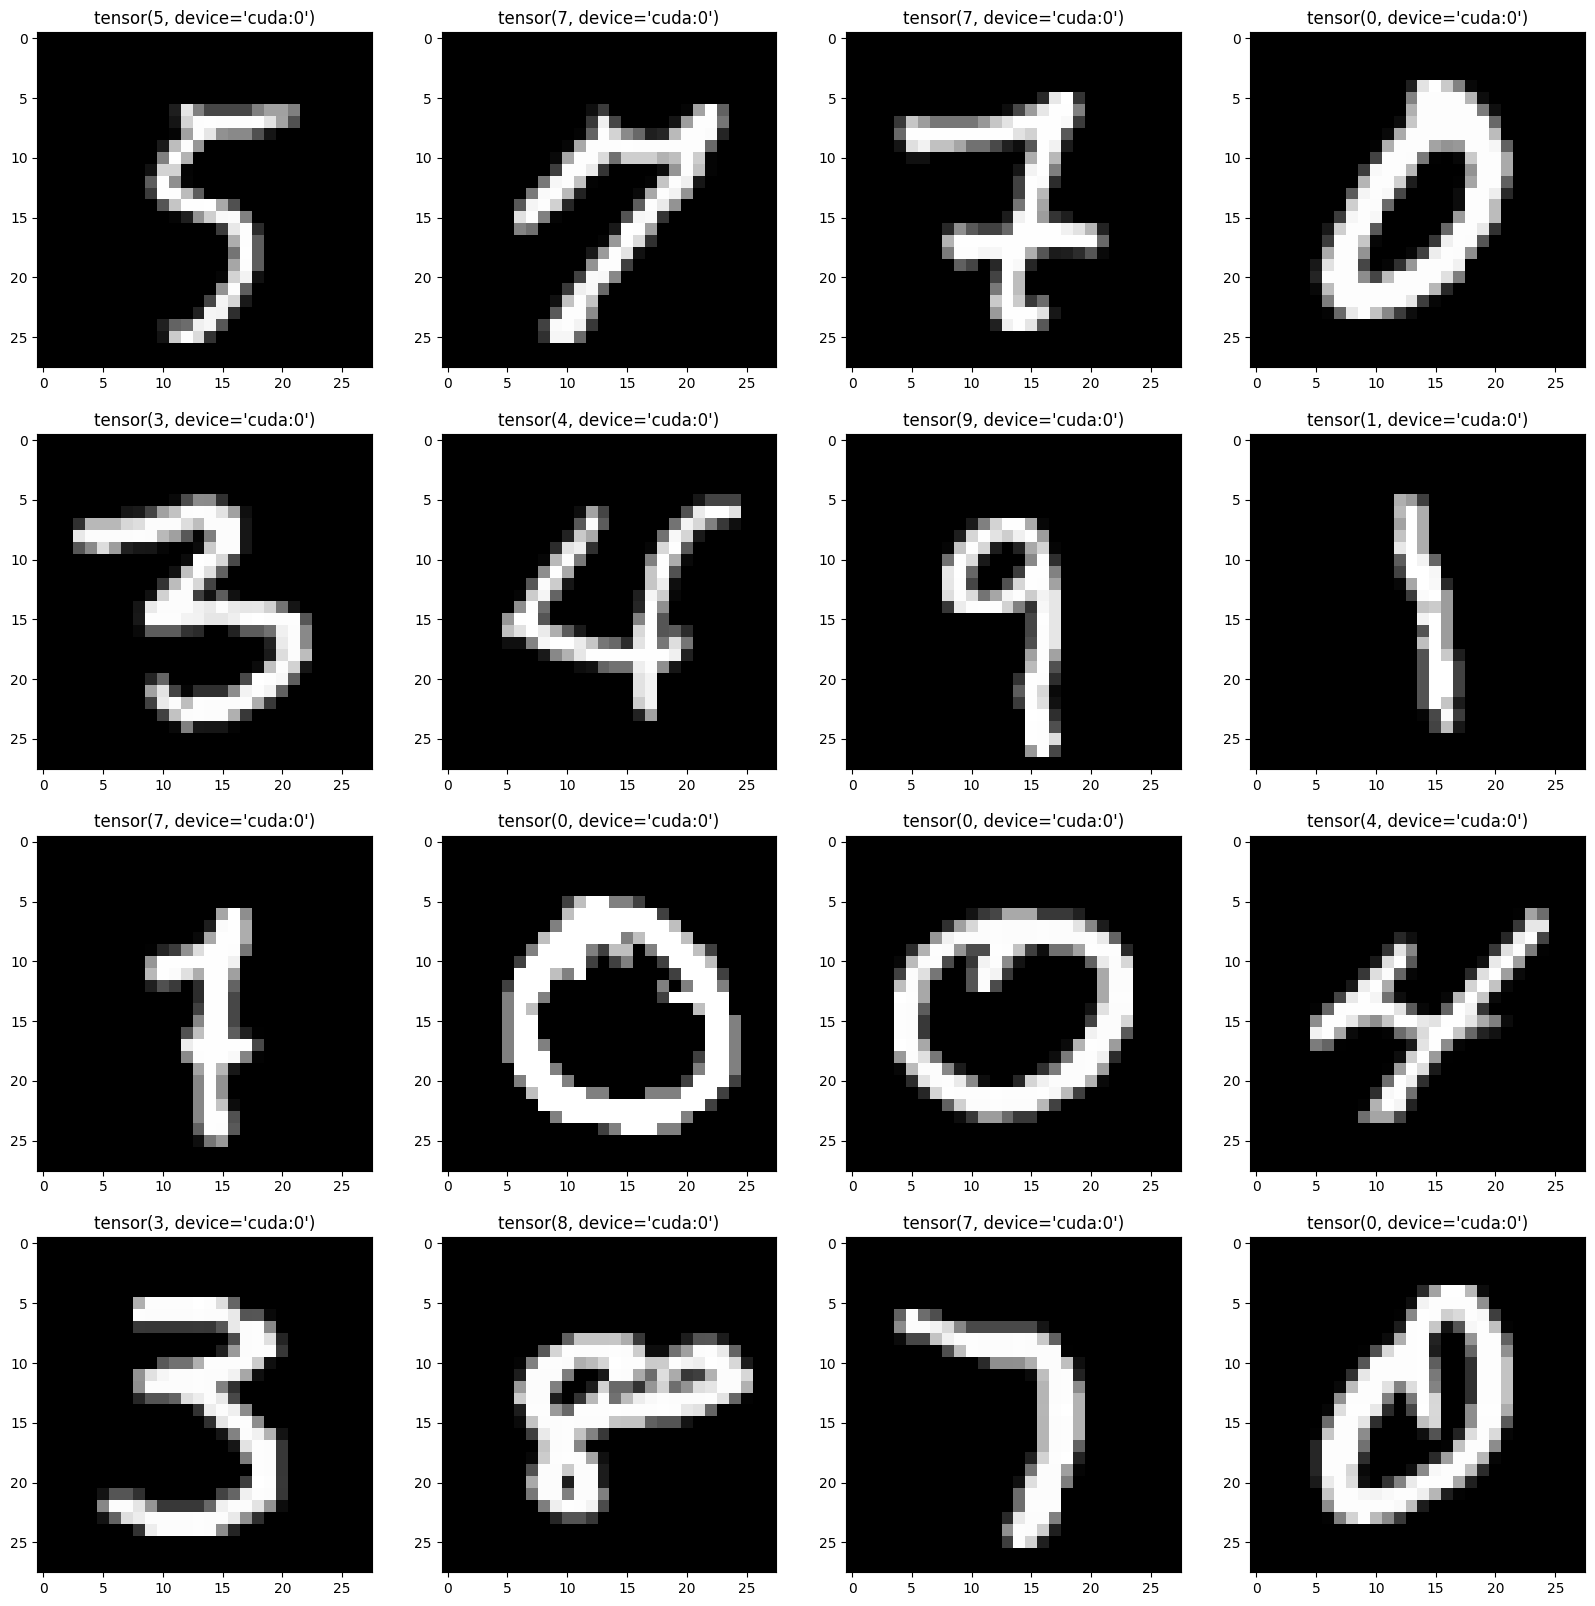

In [9]:
test_features, test_labels = next(iter(test_dataloader))

cnn.eval()

pred = cnn(test_features.to('cuda'))

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i in range(4):
    for j in range(4):
        axes[i, j].imshow(torch.reshape(test_features[i*4 + j], (28, 28)), cmap='gray')
        axes[i, j].set_title(torch.argmax(pred[i*4 + j]))

In [10]:
cnn(test_features.to('cuda'))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000

In [11]:
#torch.save(cnn.state_dict(), 'model')

tensor(3, device='cuda:0')

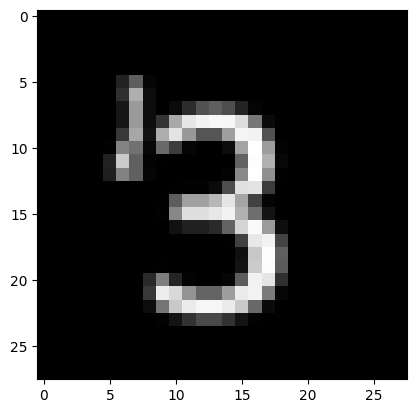

In [47]:
img = cv2.imread('./test1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (7, 7), 0)
img = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)

im = torch.from_numpy(img)
im = im[None, :, :]
im = v2.Resize(size=(28, 28))(im)
im = im.cuda().float()
im /= 255
plt.imshow(torch.reshape(im.cpu(), (28, 28)), cmap='gray')
torch.argmax(cnn(im[None, :, :, :]))